<h1>Data Preprocessing of Inflation Data</h1>

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import scipy.stats as sp

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [4]:
df = pd.read_csv('../Data/exploredData')

In [5]:
df.head()

,date,7 Day Bobc,1 Month BoBC,CHN,EUR,GBP,USD,SDR,YEN,ZAR,CPI,CPIT,CPIXA
0,2022-09-02,2.65,2.43,0.5340,0.0775,0.0670,0.0772,0.0595,10.84,1.3355,12.7,10.3,6.6
1,2022-09-01,2.65,2.43,0.5359,0.0774,0.0670,0.0775,0.0596,10.80,1.3333,12.7,10.3,6.6
2,2022-08-31,2.65,2.43,0.5395,0.0779,0.0669,0.0782,0.0599,10.82,1.3234,12.7,10.3,6.6
3,2022-08-30,2.15,2.43,0.5420,0.0783,0.0669,0.0783,0.0601,10.85,1.3191,12.7,10.3,6.6
4,2022-08-29,2.15,2.43,0.5405,0.0785,0.0669,0.0780,0.0600,10.83,1.3216,12.7,10.3,6.6


In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
df.set_index('date', inplace=True)

In [8]:
df.head()

,7 Day Bobc,1 Month BoBC,CHN,EUR,GBP,USD,SDR,YEN,ZAR,CPI,CPIT,CPIXA
date,,,,,,,,,,,,
2022-09-02,2.65,2.43,0.5340,0.0775,0.0670,0.0772,0.0595,10.84,1.3355,12.7,10.3,6.6
2022-09-01,2.65,2.43,0.5359,0.0774,0.0670,0.0775,0.0596,10.80,1.3333,12.7,10.3,6.6
2022-08-31,2.65,2.43,0.5395,0.0779,0.0669,0.0782,0.0599,10.82,1.3234,12.7,10.3,6.6
2022-08-30,2.15,2.43,0.5420,0.0783,0.0669,0.0783,0.0601,10.85,1.3191,12.7,10.3,6.6
2022-08-29,2.15,2.43,0.5405,0.0785,0.0669,0.0780,0.0600,10.83,1.3216,12.7,10.3,6.6


<AxesSubplot:xlabel='date'>

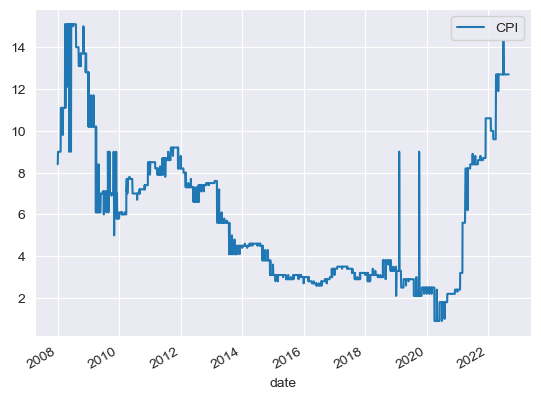

In [9]:
df[['CPI']].plot()

<h3>Feature Engineering</h3>

The dataset already has a low dimensionality and so there is no need for dimensionality reduction. Also, the data is consistent and heterogenous. There is no feature engineering that will be done on this dataset.

In addition, all features are continuous, so there is no need to create any dummy variables.

<h4>Breaking data into Training and Test sets</h4>

It is important to note that cpi, cpit, and cpixa are all measures of inflation rate even though cpi is the most common one. They will all be treated as target variables to see if the prediction model will be able to perform better predicting one of them than the others.

The data shall now be separated into test and training sets first before scaling to avoid scaling training data and testing data together. 

Also, linear model cannot handle DateTimeIndex objects, so the date column is to be converted to represent number of days from the 2nd September 2022.

In [10]:
# Converting date to number of days from September 2 2022.
df.index = (df.index[0] -  df.index).days

In [11]:
df

,7 Day Bobc,1 Month BoBC,CHN,EUR,GBP,USD,SDR,YEN,ZAR,CPI,CPIT,CPIXA
date,,,,,,,,,,,,
0,2.65,2.43,0.5340,0.077500,0.067000,0.077200,0.059500,10.8400,1.335500,12.7,10.3,6.6
1,2.65,2.43,0.5359,0.077400,0.067000,0.077500,0.059600,10.8000,1.333300,12.7,10.3,6.6
2,2.65,2.43,0.5395,0.077900,0.066900,0.078200,0.059900,10.8200,1.323400,12.7,10.3,6.6
3,2.15,2.43,0.5420,0.078300,0.066900,0.078300,0.060100,10.8500,1.319100,12.7,10.3,6.6
4,2.15,2.43,0.5405,0.078500,0.066900,0.078000,0.060000,10.8300,1.321600,12.7,10.3,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...
5237,11.96,0.00,0.0000,0.100726,0.089723,0.140546,0.091038,13.1275,1.175903,12.1,11.0,9.1
5206,11.96,0.00,0.0000,0.100726,0.089723,0.140546,0.091038,13.1275,1.175903,14.5,12.5,9.8
5176,11.96,0.00,0.0000,0.100726,0.089723,0.140546,0.091038,13.1275,1.175903,15.0,12.7,11.1


In [12]:
# Resetting index so that the time series split function gives existing indexes
df.reset_index(inplace=True)

In [13]:
df

,date,7 Day Bobc,1 Month BoBC,CHN,EUR,GBP,USD,SDR,YEN,ZAR,CPI,CPIT,CPIXA
0,0,2.65,2.43,0.5340,0.077500,0.067000,0.077200,0.059500,10.8400,1.335500,12.7,10.3,6.6
1,1,2.65,2.43,0.5359,0.077400,0.067000,0.077500,0.059600,10.8000,1.333300,12.7,10.3,6.6
2,2,2.65,2.43,0.5395,0.077900,0.066900,0.078200,0.059900,10.8200,1.323400,12.7,10.3,6.6
3,3,2.15,2.43,0.5420,0.078300,0.066900,0.078300,0.060100,10.8500,1.319100,12.7,10.3,6.6
4,4,2.15,2.43,0.5405,0.078500,0.066900,0.078000,0.060000,10.8300,1.321600,12.7,10.3,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3766,5237,11.96,0.00,0.0000,0.100726,0.089723,0.140546,0.091038,13.1275,1.175903,12.1,11.0,9.1
3767,5206,11.96,0.00,0.0000,0.100726,0.089723,0.140546,0.091038,13.1275,1.175903,14.5,12.5,9.8
3768,5176,11.96,0.00,0.0000,0.100726,0.089723,0.140546,0.091038,13.1275,1.175903,15.0,12.7,11.1
3769,5298,11.96,0.00,0.0000,0.100726,0.089723,0.140546,0.091038,13.1275,1.175903,9.8,9.7,8.9


In [14]:
X = df.drop(columns=['CPIT', 'CPIXA'])
y = df['CPI']

In [15]:
print(X)

      date  7 Day Bobc  1 Month BoBC     CHN       EUR       GBP       USD  \
0        0        2.65          2.43  0.5340  0.077500  0.067000  0.077200   
1        1        2.65          2.43  0.5359  0.077400  0.067000  0.077500   
2        2        2.65          2.43  0.5395  0.077900  0.066900  0.078200   
3        3        2.15          2.43  0.5420  0.078300  0.066900  0.078300   
4        4        2.15          2.43  0.5405  0.078500  0.066900  0.078000   
...    ...         ...           ...     ...       ...       ...       ...   
3766  5237       11.96          0.00  0.0000  0.100726  0.089723  0.140546   
3767  5206       11.96          0.00  0.0000  0.100726  0.089723  0.140546   
3768  5176       11.96          0.00  0.0000  0.100726  0.089723  0.140546   
3769  5298       11.96          0.00  0.0000  0.100726  0.089723  0.140546   
3770  5358       11.96          0.00  0.0000  0.100726  0.089723  0.140546   

           SDR      YEN       ZAR   CPI  
0     0.059500  10.84

In [21]:
tscv = TimeSeriesSplit()

In [22]:
# Split data into train and test, run linear regression model, and print R2 score, MSE, and MAE.
for train_index, test_index in tscv.split(y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
   
    
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    
    ypred = lm.predict(X_test)
    
    
    print('R2 Score: ' + str(r2_score(y_test, ypred)))
    print('Mean Squared Error: ' + str(mean_squared_error(y_test, ypred)))
    print('Mean Absolute Error: ' + str(mean_absolute_error(y_test, ypred)))

R2 Score: 1.0
Mean Squared Error: 1.2071472715749037e-26
Mean Absolute Error: 1.0553836643960604e-13
R2 Score: 1.0
Mean Squared Error: 4.15536407287475e-27
Mean Absolute Error: 6.346586384527591e-14
R2 Score: 1.0
Mean Squared Error: 1.1688802006099444e-28
Mean Absolute Error: 9.675911876398737e-15
R2 Score: 1.0
Mean Squared Error: 1.49751676458476e-28
Mean Absolute Error: 1.2000308743878284e-14
R2 Score: 1.0
Mean Squared Error: 1.8681887491281896e-28
Mean Absolute Error: 1.1576019689881409e-14


The linear regression model was able to achieve an R_squared value of 1 without any hyperparameter tuning. Cross validation was used, and for each fold, the R2 value was one, while the MSE and MAE were virtually zero. The model seems to be performing quite well with the data. 

In [23]:
rm = Ridge()

In [24]:
for train_index, test_index in tscv.split(y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
   
    
    rm = Ridge()
    rm.fit(X_train, y_train)
    
    ypred = rm.predict(X_test)
    
    
    print('R2 Score: ' + str(r2_score(y_test, ypred)))
    print('Mean Squared Error: ' + str(mean_squared_error(y_test, ypred)))
    print('Mean Absolute Error: ' + str(mean_absolute_error(y_test, ypred)))

R2 Score: 0.9995975773894269
Mean Squared Error: 8.206517654680771e-05
Mean Absolute Error: 0.008143939706403381
R2 Score: 0.9998834105164337
Mean Squared Error: 8.318970530938965e-06
Mean Absolute Error: 0.002598197272248581
R2 Score: 0.9999977692096315
Mean Squared Error: 4.519875735785023e-06
Mean Absolute Error: 0.0018697179231476904
R2 Score: 0.9999996204033416
Mean Squared Error: 2.139912733110121e-07
Mean Absolute Error: 0.00041423974609692475
R2 Score: 0.9999999367046288
Mean Squared Error: 9.239162466804576e-07
Mean Absolute Error: 0.0006974275110133107


Metrics for Ridge Regression are similar though not as accurate as those for the Linear Regression Model.

In [25]:
for train_index, test_index in tscv.split(y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
   
    
    rm = Ridge()
    grid_search = GridSearchCV(rm, param_grid={'alpha':[0.001, 0.01, 0.1, 1, 10], 'solver':['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},  cv=5)
    grid_search.fit(X_train, y_train)
    ypred = grid_search.predict(X_test)
    
    
    print('R2 Score: ' + str(r2_score(y_test, ypred)))
    print('Mean Squared Error: ' + str(mean_squared_error(y_test, ypred)))
    print('Mean Absolute Error: ' + str(mean_absolute_error(y_test, ypred)))

R2 Score: 0.9999999993310951
Mean Squared Error: 1.36408333765203e-10
Mean Absolute Error: 1.0268186039967693e-05
R2 Score: 0.9999999996823258
Mean Squared Error: 2.266690356354523e-11
Mean Absolute Error: 4.02036077863186e-06
R2 Score: 0.9999999999827247
Mean Squared Error: 3.5002056234414823e-11
Mean Absolute Error: 4.601306617113201e-06
R2 Score: 0.9999999999859716
Mean Squared Error: 7.908309776999712e-12
Mean Absolute Error: 2.5989982506800762e-06
R2 Score: 0.9999999999999115
Mean Squared Error: 1.2921035066468552e-12
Mean Absolute Error: 8.093229008999903e-07


Hyper parameter tuning makes Ridge Regression model slightly more accurate, though it's quite negligible.

In [26]:
df.to_csv('../Data/PreprocessedData')